In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Exclude the high expressed genes on the regressedout data


Has a tigter distribution in pca and a little bit more (70) HVG (increase from 4771 to 4843)

In [0]:
# notes: scanpy has several versions, afer 17May2020, it become 1.5.1 from 1.4.6
!pip install scanpy
!pip install leidenalg

In [0]:
#!pip install bbknn==1.3.6
#pip install umap-learn==0.3.9

In [1]:
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# notice that scanpy already became 1.5.1 after 17May2020
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, figsize=(4, 4))

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.5 scipy==1.4.1 pandas==1.0.4 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.2 leidenalg==0.8.0


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/Florian_data")

## Extract the hypothalamic data

Use the one has donor label

In [4]:
adata = sc.read_h5ad("concat_florian_whole_donor_raw.h5ad")
adata_h = adata[adata.obs.batch.str.contains("hypo")]
del adata
adata = adata_h
adata.var_names_make_unique() 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 8 cells that have less than 200 genes expressed
filtered out 7551 genes that are detected in less than 3 cells


In [0]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
#sc.pl.highest_expr_genes(adata, n_top=20, save="_heg_hypothalamic_all")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'],percent_top=None, log1p=False, inplace=True)
#sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True, save="_violin_hypothalamic_all")
adata = adata[adata.obs.n_genes_by_counts < 11000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

## Exclude highly expressed genes

In [6]:
#exlude_highly_expressed=True
sc.pp.normalize_total(adata, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata, save="_hypothalamic")
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['UTS2', 'SST', 'GNRH1', 'NEAT1', 'MALAT1', 'MT-CO1', 'MT-CO2']
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:44)


### Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

### Here we can try exlude_highly_expressed=True next time

## PCA anaysis

In [7]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)


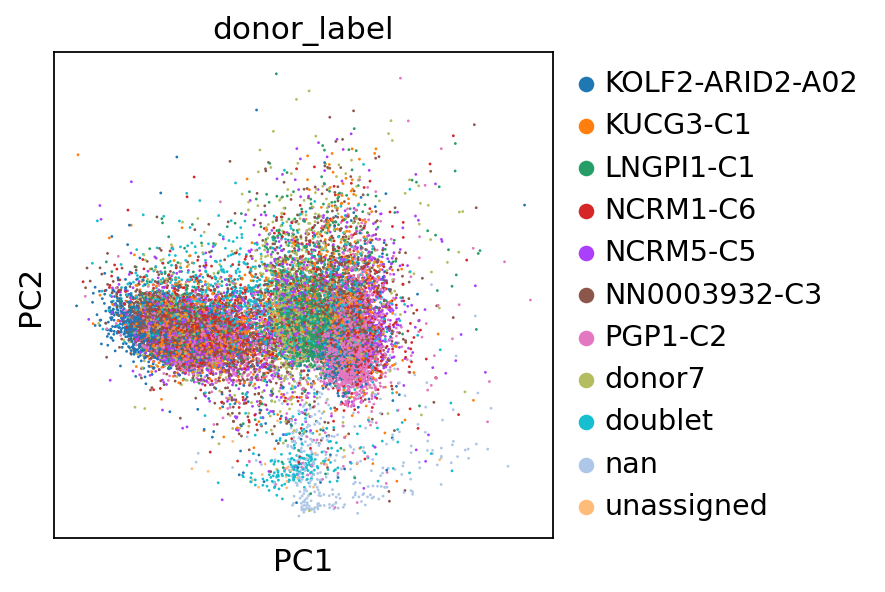

In [8]:
sc.pl.pca(adata, color="donor_label")

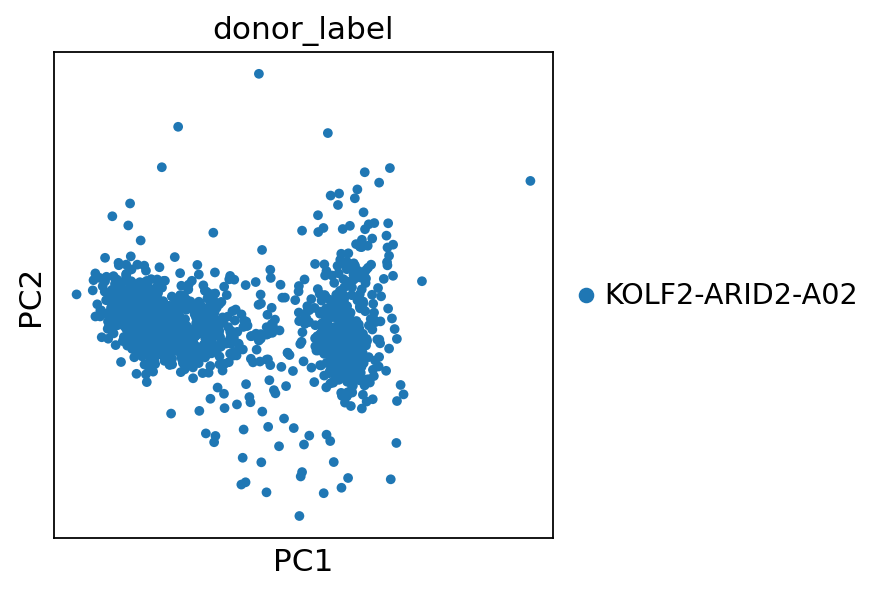

Trying to set attribute `.uns` of view, copying.


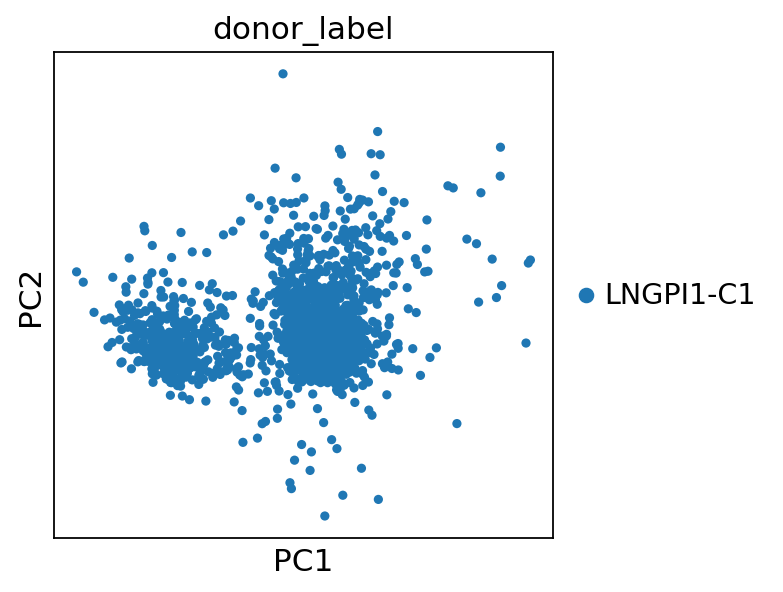

In [9]:
sc.pl.pca(adata[adata.obs.donor_label.str.contains("KOLF2")], color="donor_label")
sc.pl.pca(adata[adata.obs.donor_label.str.contains("LNGP")], color="donor_label")

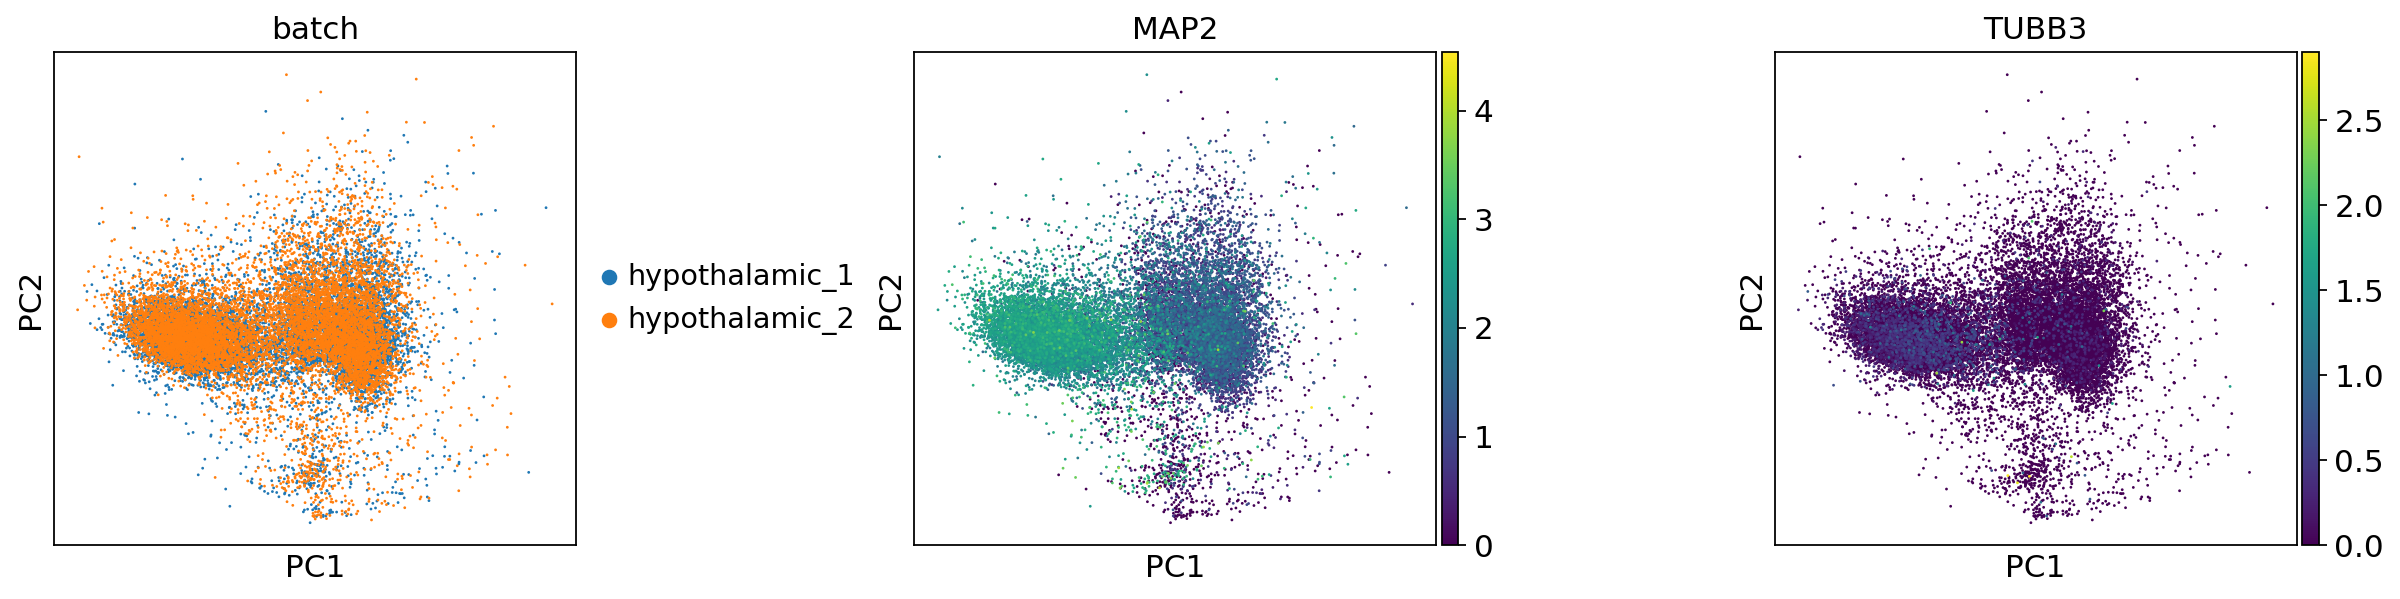

In [10]:
# plot the neuron markers and batch
sc.pl.pca(adata, color=["batch", "MAP2", "TUBB3"], wspace=0.5)

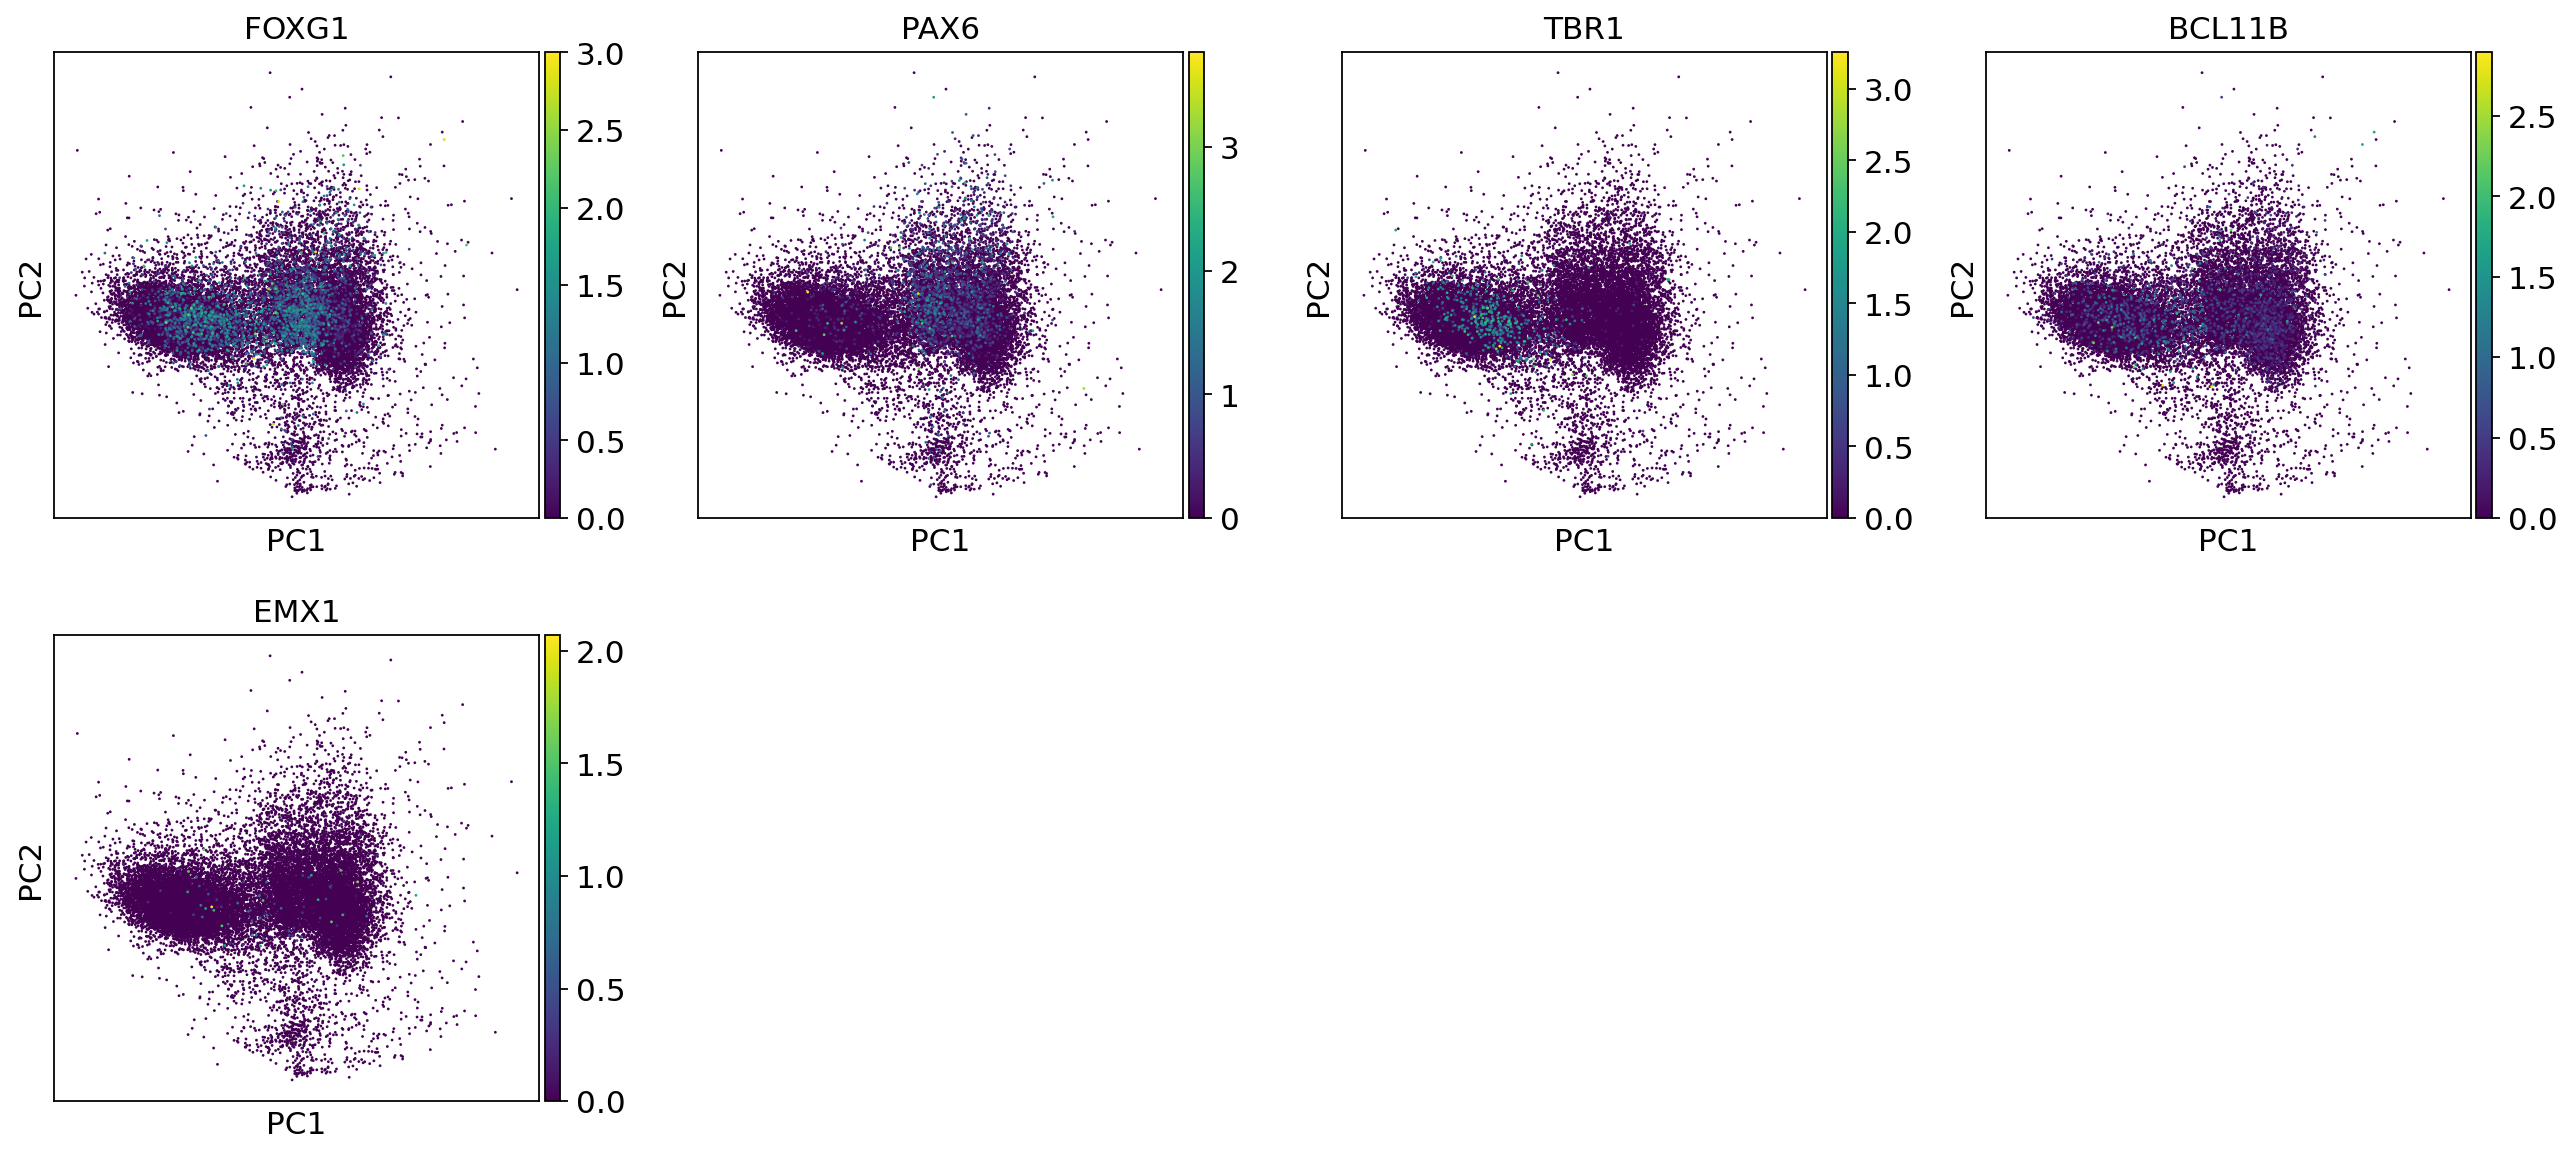

In [11]:
# plot the cortical markers
sc.pl.pca(adata, color=["FOXG1", "PAX6", "TBR1","BCL11B", "EMX1"])

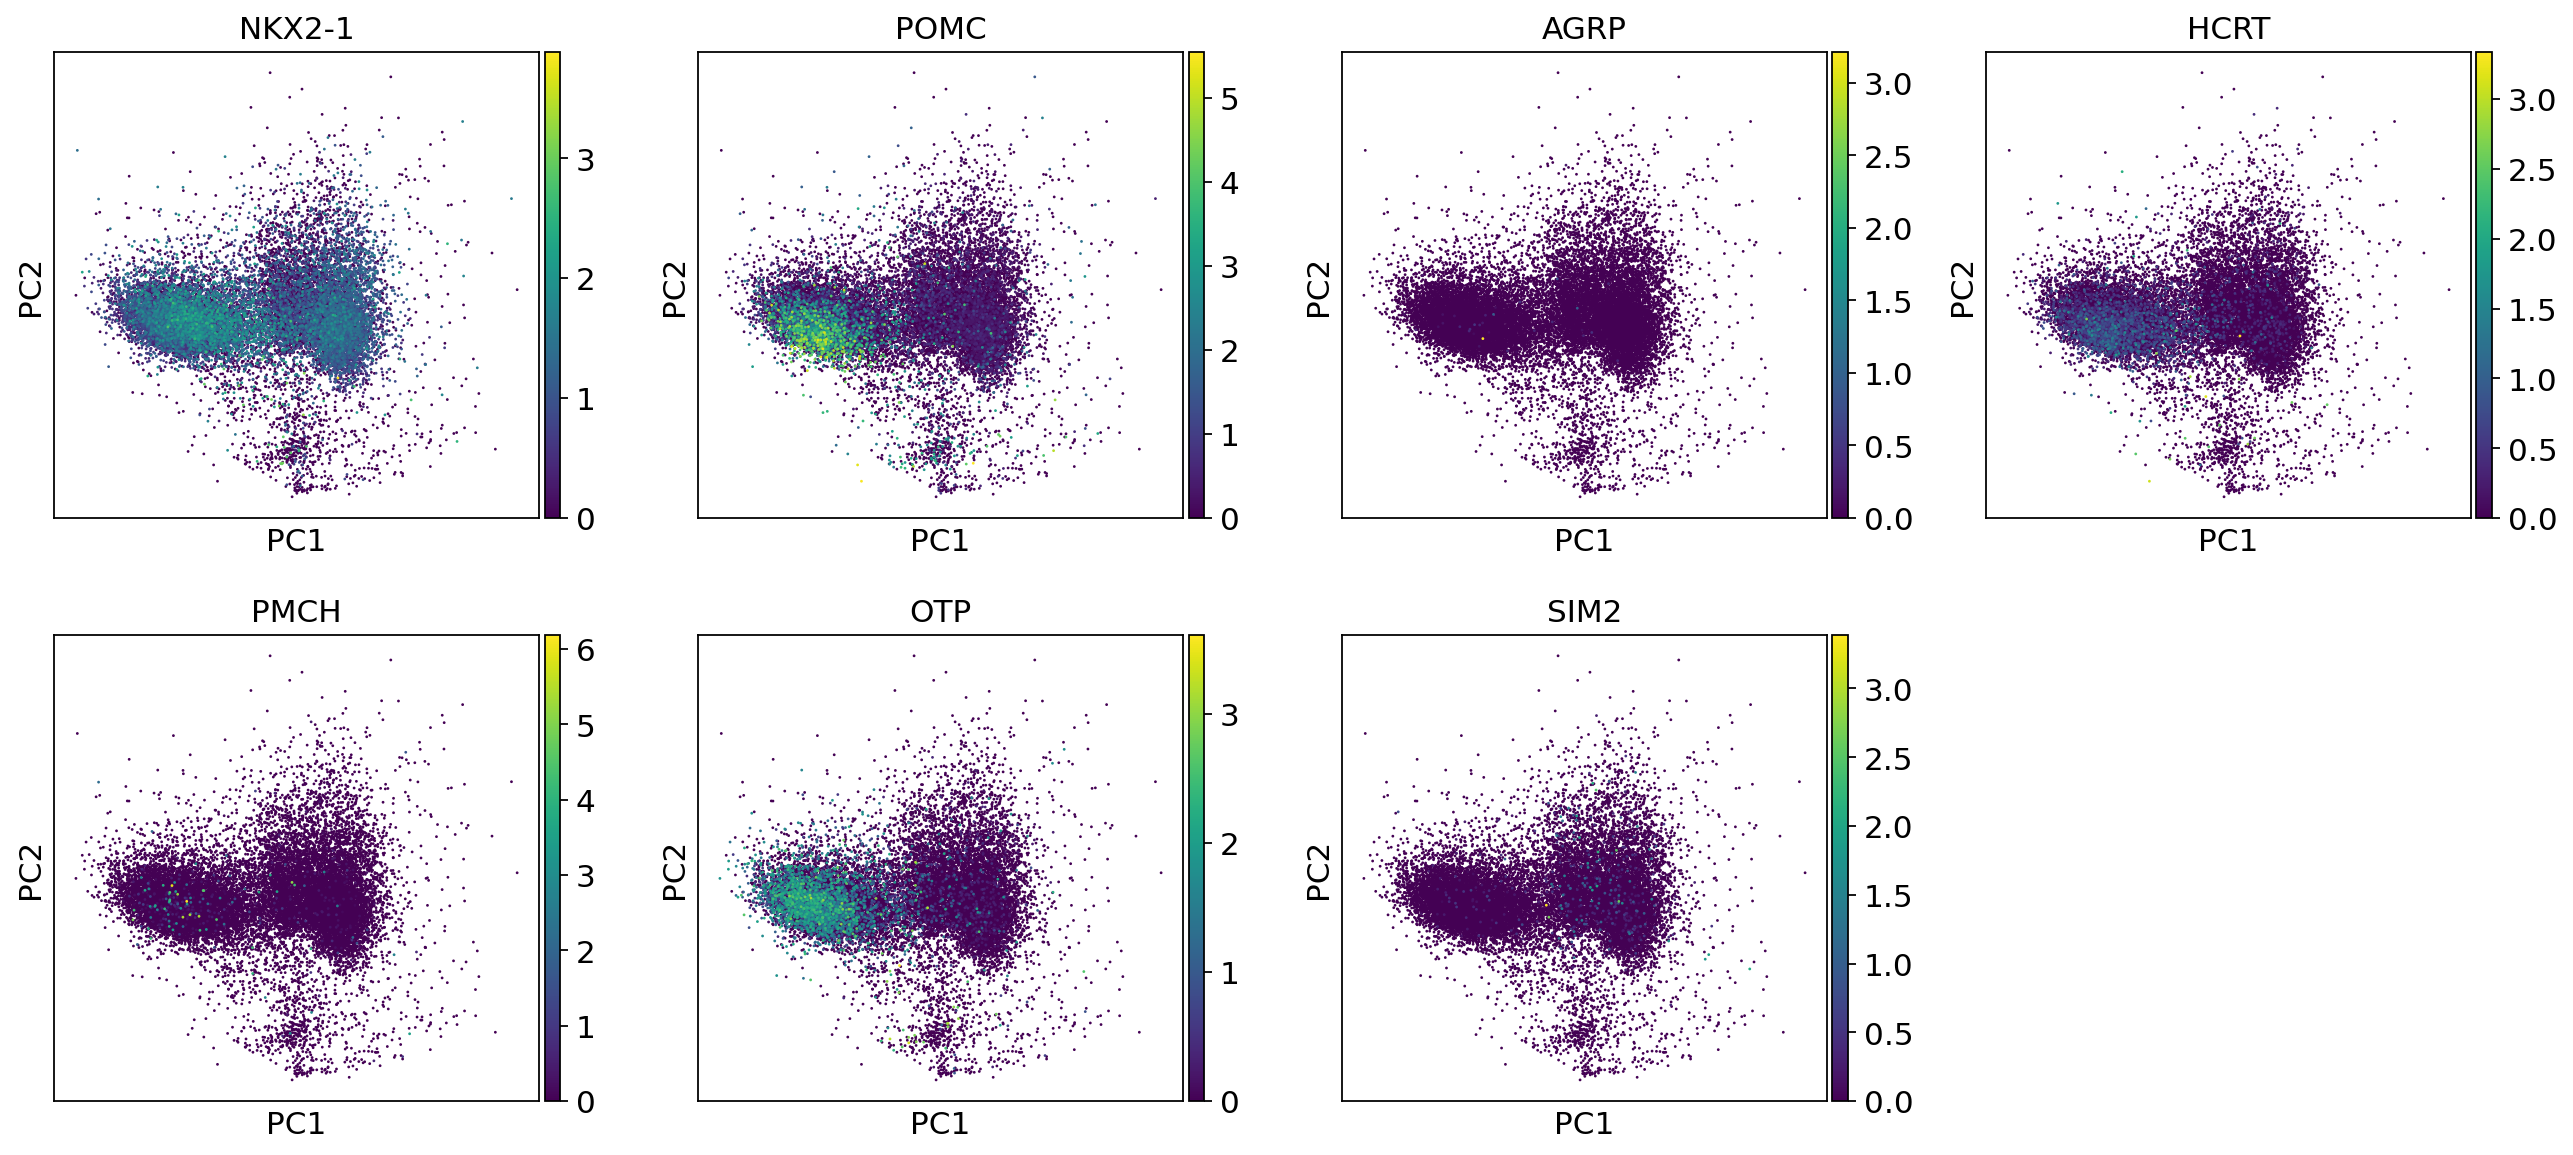

In [12]:
# plot the hypothalamic markers
sc.pl.pca(adata, color=["NKX2-1", "POMC", "AGRP", "HCRT", "PMCH", "OTP", "SIM2"])

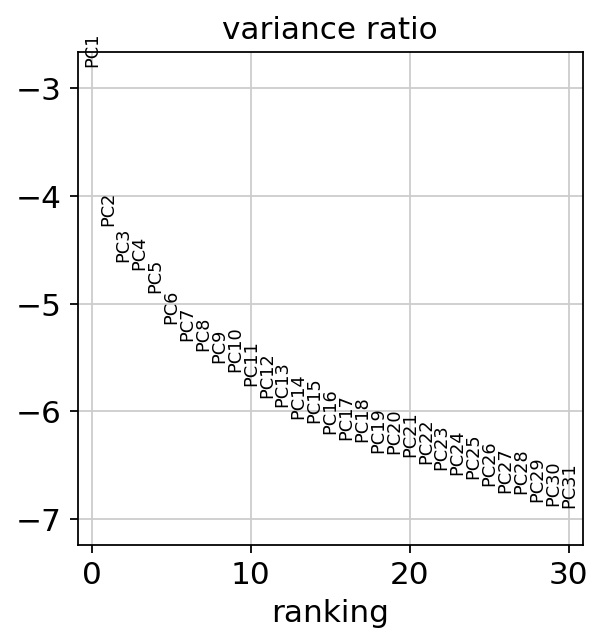

In [13]:
sc.pl.pca_variance_ratio(adata, log=True)

In [0]:
#not execulte yet
out_dir = 'hypothalamic_exclude_heg.h5ad'
adata.write(out_dir)

In [15]:
adata

AnnData object with n_obs × n_vars = 19182 × 4843
    obs: 'donor_label', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'pca', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'